In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt
import gc
pd.set_option('display.max_columns', None)

In [2]:
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
## for plotting
import matplotlib.pyplot as plt
## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import LabelEncoder,Normalizer,StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## for explainer
#from lime import lime_tabular

In [3]:
#to compute information gain
def compute_impurity(feature, impurity_criterion):
    """
    This function calculates impurity of a feature.
    Supported impurity criteria: 'entropy', 'gini'
    input: feature (this needs to be a Pandas series)
    output: feature impurity
    """
    probs = feature.value_counts(normalize=True)
    
    if impurity_criterion == 'entropy':
        impurity = -1 * np.sum(np.log2(probs) * probs)
    elif impurity_criterion == 'gini':
        impurity = 1 - np.sum(np.square(probs))
    else:
        raise ValueError('Unknown impurity criterion')
    return(round(impurity, 3))

def comp_feature_information_gain(df, target, descriptive_feature, split_criterion):
    """
    This function calculates information gain for splitting on 
    a particular descriptive feature for a given dataset
    and a given impurity criteria.
    Supported split criterion: 'entropy', 'gini'
    """
    
    print('target feature:', target)
    print('descriptive_feature:', descriptive_feature)
    print('split criterion:', split_criterion)
            
    target_entropy = compute_impurity(df[target], split_criterion)

    # we define two lists below:
    # entropy_list to store the entropy of each partition
    # weight_list to store the relative number of observations in each partition
    entropy_list = list()
    weight_list = list()
    
    # loop over each level of the descriptive feature
    # to partition the dataset with respect to that level
    # and compute the entropy and the weight of the level's partition
    for level in df[descriptive_feature].unique():
        df_feature_level = df[df[descriptive_feature] == level]
        entropy_level = compute_impurity(df_feature_level[target], split_criterion)
        entropy_list.append(round(entropy_level, 3))
        weight_level = len(df_feature_level) / len(df)
        weight_list.append(round(weight_level, 3))

   # print('impurity of partitions:', entropy_list)
   # print('weights of partitions:', weight_list)

    feature_remaining_impurity = np.sum(np.array(entropy_list) * np.array(weight_list))
    print('remaining impurity:', feature_remaining_impurity)
    
    information_gain = target_entropy - feature_remaining_impurity
    print('information gain:', information_gain)
    
    print('====================')

    return(information_gain)

In [4]:
#a = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
#b = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
a = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week1.csv', low_memory=False, encoding='cp1252')
b = pd.read_csv('./CIDDS-001/traffic/OpenStack/CIDDS-001-internal-week2.csv', low_memory=False, encoding='cp1252')
c =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
d =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
e =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('./CIDDS-001/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#c = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week3.csv', low_memory=False , encoding='cp1252')
#d = pd.read_csv('drive/My Drive/Colab Notebooks/traffic/OpenStack/CIDDS-001-internal-week4.csv', low_memory=False, encoding='cp1252')
#e =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week1.csv', low_memory=False, encoding='cp1252')
#f =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week2.csv', low_memory=False, encoding='cp1252')
#g =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week3.csv', low_memory=False, encoding='cp1252')
#h =  pd.read_csv('drive/My Drive/Colab Notebooks/traffic/ExternalServer/CIDDS-001-external-week4.csv', low_memory=False, encoding='cp1252')

In [5]:
print(b.shape)
#a.drop(a[a['attackType'] == '---'].index, axis = 0, inplace= True) 
b.drop(b[b['attackType'] == '---'].index, axis = 0, inplace= True)  
c.drop(c[c['attackType'] == '---'].index, axis = 0, inplace= True)  
d.drop(d[d['attackType'] == '---'].index, axis = 0, inplace= True)  
#e.drop(e[e['attackType'] == '---'].index, axis = 0, inplace= True)  
b.shape

(10310733, 16)


(1795404, 16)

In [6]:
data_external = pd.concat([c,d,e], axis = 0)
data_external.reset_index(drop= True, inplace= True)

In [7]:
#to Increment attackID values
data_external['attackID'] = data_external['attackID'].apply(lambda x: str(int(x) + 70) if x != '---' else x)

In [8]:
def convert_bytes(df):
    if 'M' in df:
        df = df.split('M')
        df = df[0].strip()
        df = float(df) * 1000000
    elif 'B' in df:
        df = df.split('B')
        df = df[0].strip()
        df =  float(df) * 1000000000
    else: 
        df =float(df)
    return df

In [9]:
data = pd.concat([a,b,data_external], axis = 0)
data.reset_index(drop= True, inplace= True)
data['Bytes'] = data['Bytes'].apply(lambda x: convert_bytes(x))
data['attackType'] = data['attackType'].apply(lambda x:  'attack' if (x!= '---') else x )

columns = ['Src Pt', 'Dst Pt','Tos','Flows','Packets', 'Bytes']
for i in columns:
    data[i] = pd.to_numeric(data[i]);
del columns
del a,b,c,d,e, data_external
gc.collect()

0

In [10]:
#Converts Hexadecimal value to Binary
def hex_to_binary(hexdata):
    scale = 16 ## equals to hexadecimal
    num_of_bits = 9
    return bin(int(hexdata, scale))[2:].zfill(num_of_bits);
#Converts TCP flags to Binary
def to_Binary(x):
    l = 0
    x = '...' + x
    x = list(x)
    for i in x:
        if (i=='.'):
            x[l]= '0'
        else:
            x[l] = '1'
        l = l +1
    return ''.join(x)
#Converts the 'Flags' column to 9 indiviual columns (manual oneshot encoding)
def flag_convert(df):  
   # df['Flags'] = df['Flags'].apply(lambda x: (list(x)))
   # temp = df['Flags'].apply(lambda x: toBinary(x))
    hex_values = list(df[(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    flag_values = list(df[~(df['Flags'].str.contains("0x", na=False))]['Flags'].unique())
    binary_values = {}
    for i in hex_values:
         binary_values[i] = (hex_to_binary(i))
    for i in flag_values:
         binary_values[i] = (to_Binary(i))
    temp = df['Flags'].replace(binary_values)
#temp = temp.apply(lambda x: pd.Series(x)) 
    temp = pd.DataFrame(temp.apply(list).tolist())
#temp = pd.DataFrame(temp)
#a = a.iloc[: , 1:]
   # print(temp.head())
    temp.columns = ['N','C','E','U' ,'A','P','R','S','F']
    for i in temp.columns:
        temp[i] = pd.to_numeric(temp[i]);
    temp = temp.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp], axis = 1)
    return df;

In [11]:
#make a IP_pairs 
def make_pair(df):
    ip_pair = df['Src IP Addr'] +'/' +df['Dst IP Addr']
    source_ip = df['Src IP Addr'].unique().tolist()
    destination_ip = df['Dst IP Addr'].unique().tolist()
   # df = df.drop(columns = ['Src IP Addr', 'Dst IP Addr'])
    df.insert(1, ' IP Pair', ip_pair)
    return df

def check_inverse(df):
    list_pairs = df[' IP Pair'].unique()
    tuple_pair = []
    for i in list_pairs:
        tuple_pair.append(tuple((i.split('/'))))
    dic_store = {}
    for i in tuple_pair:
        if (i  not in dic_store.keys()) and (i[::-1] not in dic_store.keys()):
            dic_store[i] = i[0] + '/' +i[1]
    print(len(dic_store.keys()))
    dic_final = {}
    for i in dic_store.keys():
        dic_final[i[0] + '/' +i[1]] = dic_store[i]
        dic_final[i[1] + '/' +i[0]] = dic_store[i]
    df[' IP Pair'] = df[' IP Pair'].map(dic_final)               
    return df

In [12]:
def normalize_IP(df):
    columns = ['sourceIP_feature 1', 'sourceIP_feature 2', 'sourceIP_feature 3', 'sourceIP_feature 4', 'destIP_feature 1',
              'destIP_feature 2', 'destIP_feature 3', 'destIP_feature 4']
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [13]:
def normalize(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    columns = data.select_dtypes(include=numerics).columns
    normalized = df[columns]
    print(columns)
    transformed = MinMaxScaler().fit(normalized).transform(normalized)
    transformed = pd.DataFrame(transformed)
    j = 0
    col = {}
    for i in columns:
        col[j] = i
        j=j+1
    transformed = transformed.rename(columns = col)
    transformed = transformed.reset_index()
    for i in columns:
        df[i] = transformed[i].to_numpy()
    return df;

In [14]:
def one_shot(df):
    label_encoder = LabelEncoder()
    #df.astype({'attackType': 'str'})
    df['attackType'] = label_encoder.fit_transform(df['attackType'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    
    df['sourceIP_feature 1'] = label_encoder.fit_transform(df['sourceIP_feature 1'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['sourceIP_feature 2'] = label_encoder.fit_transform(df['sourceIP_feature 2'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['sourceIP_feature 3'] = label_encoder.fit_transform(df['sourceIP_feature 3'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['sourceIP_feature 4'] = label_encoder.fit_transform(df['sourceIP_feature 4'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['destIP_feature 1'] = label_encoder.fit_transform(df['destIP_feature 1'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['destIP_feature 2'] = label_encoder.fit_transform(df['destIP_feature 2'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['destIP_feature 3'] = label_encoder.fit_transform(df['destIP_feature 3'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['destIP_feature 4'] = label_encoder.fit_transform(df['destIP_feature 4'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    df['Proto'] = label_encoder.fit_transform(df['Proto'])
    print(list(label_encoder.classes_))
    print(list(label_encoder.transform(label_encoder.classes_)))
    
    onehot_encoder1 = OneHotEncoder()
    onehot_encoder1.fit(df.Proto.to_numpy().reshape(-1, 1))
    proto = onehot_encoder1.transform(df.Proto.to_numpy().reshape(-1, 1))
    proto = pd.DataFrame.sparse.from_spmatrix(proto)
    proto.astype('int32')
    proto.columns = label_encoder.classes_
   # print(proto.head(1))
    df = pd.concat([df, proto], axis = 1)
    return df;

In [15]:
def drop_columns(df):
    return df.drop(columns = ['Date first seen', ' IP Pair', 'Flows', 'class', 'attackID','Flags',
                              'attackDescription', 'Src IP Addr', 'Dst IP Addr','Proto'], axis =1)

In [16]:
#Aplit IP address into features, 7 features
def split_to_net(IP_address):
    IP_list = IP_address.split(".")
    needed_len = 7
    needed_len = needed_len - len(IP_list)
    for i in range(0,needed_len,1):
        IP_list.append('0')
    return IP_list
#replace unknown IP address, and convert to columns
def IP_split(df): 
    replace = {"ATTACKER1":"0.0.0.0",
           "ATTACKER2":"0.0.0.0",
           "ATTACKER3":"0.0.0.0",
           "EXT_SERVER": "0.0.0.0.1",
          "OPENSTACK_NET": "0.0.0.0.0.1",
          "DNS": "0.0.0.0.0.0.1"}
    df = df.replace({"Src IP Addr": replace, "Dst IP Addr": replace}, value=None)
    temp_source = df["Src IP Addr"].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
    temp_des = df['Dst IP Addr'].apply(lambda x: "0.0.0.0.0.0.0" if ('_') in x else x)
   # sourceIP = list(df["Src IP Addr"].unique())
   # destIP = list(df["Dst IP Addr"].unique())
   # sourceIP_values = {}
   # desIP_values = {}
   # for i in sourceIP:
   #      sourceIP_values[i] = (split_to_net(i))
   # for i in destIP:
   #      desIP_values[i] = (split_to_net(i))
    #print(sourceIP_values)
   # print(desIP_values)
#for Source IP
    temp_source = temp_source.apply(lambda x: split_to_net(x) )
    temp_source = pd.DataFrame(temp_source.apply(list).tolist())
    temp_source.columns = ['sourceIP_feature 1','sourceIP_feature 2','sourceIP_feature 3','sourceIP_feature 4' ,
                    'sourceEXT_SERVER','sourceOPENSTACK_NET','sourceDNS']
    for i in temp_source.columns:
        temp_source[i] = pd.to_numeric(temp_source[i]);
    temp_source = temp_source.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_source], axis = 1)
    #for Destination IP
    temp_des = temp_des.apply(lambda x: split_to_net(x) )
    temp_des = pd.DataFrame(temp_des.apply(list).tolist())
    temp_des.columns = ['destIP_feature 1','destIP_feature 2','destIP_feature 3','destIP_feature 4' ,
                    'destEXT_SERVER','destOPENSTACK_NET','destDNS']
    for i in temp_des.columns:
        temp_des[i] = pd.to_numeric(temp_des[i]);
    temp_des = temp_des.reset_index(drop=True)
    df = df.reset_index(drop=True)
    df = pd.concat([df, temp_des], axis = 1)
    return df;

In [17]:
data = make_pair(data)
data = check_inverse(data)

59362


In [18]:
data = IP_split(data)

In [19]:
data = normalize(data)
data =  one_shot(data) 
data = normalize_IP(data)

Index(['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Tos',
       'sourceIP_feature 1', 'sourceIP_feature 2', 'sourceIP_feature 3',
       'sourceIP_feature 4', 'sourceEXT_SERVER', 'sourceOPENSTACK_NET',
       'sourceDNS', 'destIP_feature 1', 'destIP_feature 2', 'destIP_feature 3',
       'destIP_feature 4', 'destEXT_SERVER', 'destOPENSTACK_NET', 'destDNS'],
      dtype='object')
['---', 'attack']
[0, 1]
[0.0, 1.0]
[0, 1]
[0.0, 1.0]
[0, 1]
[0.0, 0.003952569169960474, 0.01976284584980237, 0.3162055335968379, 0.3952569169960474, 0.7905138339920948, 0.8300395256916996, 0.8695652173913043, 0.9999999999999999]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[0.0, 0.004, 0.008, 0.012, 0.016, 0.02, 0.024, 0.028, 0.032, 0.036000000000000004, 0.04, 0.044, 0.048, 0.052000000000000005, 0.056, 0.06, 0.064, 0.4, 0.432, 0.456, 0.612, 0.884, 0.96, 1.0]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[0.0, 0.7529411764705882, 1.0]
[0, 1, 2]
[0.0, 0.6588235294117647,

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


['sourceIP_feature 1', 'sourceIP_feature 2', 'sourceIP_feature 3', 'sourceIP_feature 4', 'destIP_feature 1', 'destIP_feature 2', 'destIP_feature 3', 'destIP_feature 4']


In [20]:
data_ig = flag_convert(data)
data_ig = drop_columns(data)

In [25]:
split_criterion = 'entropy'
feature_info_gain = {}
for feature in data_ig.drop(columns='attackType').columns:
    feature_info_gain[feature] = comp_feature_information_gain(data_ig, 'attackType', feature, split_criterion)
feature_info_gain

target feature: attackType
descriptive_feature: Duration
split criterion: entropy
remaining impurity: 0.36495600000000006
information gain: 0.530044
target feature: attackType
descriptive_feature: Src Pt
split criterion: entropy
remaining impurity: 0.267853
information gain: 0.627147
target feature: attackType
descriptive_feature: Dst Pt
split criterion: entropy
remaining impurity: 0.2693620000000001
information gain: 0.6256379999999999
target feature: attackType
descriptive_feature: Packets
split criterion: entropy
remaining impurity: 0.46965899999999994
information gain: 0.4253410000000001
target feature: attackType
descriptive_feature: Bytes
split criterion: entropy
remaining impurity: 0.063283
information gain: 0.831717
target feature: attackType
descriptive_feature: Tos
split criterion: entropy
remaining impurity: 0.751886
information gain: 0.14311399999999996
target feature: attackType
descriptive_feature: sourceIP_feature 1
split criterion: entropy
remaining impurity: 0.67981600

C:\Users\hp\Anaconda3\lib\site-packages\pandas\core\indexing.py:2418: FutureWarning: DataFrame/Series.to_dense is deprecated and will be removed in a future version
  result = result.to_dense()


remaining impurity: 0.895
information gain: 0.0
target feature: attackType
descriptive_feature: ICMP 
split criterion: entropy
remaining impurity: 0.893228
information gain: 0.0017719999999999958
target feature: attackType
descriptive_feature: IGMP 
split criterion: entropy
remaining impurity: 0.895
information gain: 0.0
target feature: attackType
descriptive_feature: TCP  
split criterion: entropy
remaining impurity: 0.8482480000000001
information gain: 0.046751999999999905
target feature: attackType
descriptive_feature: UDP  
split criterion: entropy
remaining impurity: 0.8418270000000001
information gain: 0.053172999999999915
target feature: attackType
descriptive_feature: N
split criterion: entropy
remaining impurity: 0.895
information gain: 0.0
target feature: attackType
descriptive_feature: C
split criterion: entropy
remaining impurity: 0.894105
information gain: 0.0008949999999999791
target feature: attackType
descriptive_feature: E
split criterion: entropy
remaining impurity: 0

{'Duration': 0.530044,
 'Src Pt': 0.627147,
 'Dst Pt': 0.6256379999999999,
 'Packets': 0.4253410000000001,
 'Bytes': 0.831717,
 'Tos': 0.14311399999999996,
 'sourceIP_feature 1': 0.21518399999999993,
 'sourceIP_feature 2': 0.21518399999999993,
 'sourceIP_feature 3': 0.3792920000000001,
 'sourceIP_feature 4': 0.59624,
 'sourceEXT_SERVER': 0.005506000000000011,
 'sourceOPENSTACK_NET': 0.0007920000000000149,
 'sourceDNS': 0.025863999999999998,
 'destIP_feature 1': 0.218016,
 'destIP_feature 2': 0.218016,
 'destIP_feature 3': 0.36960800000000005,
 'destIP_feature 4': 0.571121,
 'destEXT_SERVER': 0.0049000000000000155,
 'destOPENSTACK_NET': 0.0007920000000000149,
 'destDNS': 0.025863999999999998,
 'GRE  ': 0.0,
 'ICMP ': 0.0017719999999999958,
 'IGMP ': 0.0,
 'TCP  ': 0.046751999999999905,
 'UDP  ': 0.053172999999999915,
 'N': 0.0,
 'C': 0.0008949999999999791,
 'E': 0.0008949999999999791,
 'U': 0.0,
 'A': 0.015453999999999968,
 'P': 0.0071149999999999824,
 'R': 0.0010799999999999699,
 'S': 

In [30]:
feature_info_gain = pd.DataFrame.from_dict([feature_info_gain]).transpose()
feature_info_gain = pd.DataFrame(feature_info_gain[0].sort_values(ascending = False))
feature_info_gain.columns = ['entropy']
feature_info_gain

,entropy
Bytes,0.831717
Src Pt,0.627147
Dst Pt,0.625638
sourceIP_feature 4,0.596240
destIP_feature 4,0.571121
Duration,0.530044
Packets,0.425341
S,0.416994
sourceIP_feature 3,0.379292
F,0.375580


In [28]:
split_criterion = 'gini'
feature_info_gain1 = {}
for feature in data_ig.drop(columns='attackType').columns:
    feature_info_gain1[feature] = comp_feature_information_gain(data_ig, 'attackType', feature, split_criterion)
feature_info_gain1

target feature: attackType
descriptive_feature: Duration
split criterion: gini
remaining impurity: 0.14231299999999997
information gain: 0.286687
target feature: attackType
descriptive_feature: Src Pt
split criterion: gini
remaining impurity: 0.13233399999999998
information gain: 0.296666
target feature: attackType
descriptive_feature: Dst Pt
split criterion: gini
remaining impurity: 0.132656
information gain: 0.296344
target feature: attackType
descriptive_feature: Packets
split criterion: gini
remaining impurity: 0.20162500000000003
information gain: 0.22737499999999997
target feature: attackType
descriptive_feature: Bytes
split criterion: gini
remaining impurity: 0.023725999999999997
information gain: 0.405274
target feature: attackType
descriptive_feature: Tos
split criterion: gini
remaining impurity: 0.371657
information gain: 0.05734299999999998
target feature: attackType
descriptive_feature: sourceIP_feature 1
split criterion: gini
remaining impurity: 0.334704
information gain: 

{'Duration': 0.286687,
 'Src Pt': 0.296666,
 'Dst Pt': 0.296344,
 'Packets': 0.22737499999999997,
 'Bytes': 0.405274,
 'Tos': 0.05734299999999998,
 'sourceIP_feature 1': 0.09429599999999999,
 'sourceIP_feature 2': 0.09429599999999999,
 'sourceIP_feature 3': 0.19132000000000002,
 'sourceIP_feature 4': 0.302551,
 'sourceEXT_SERVER': 0.0027630000000000154,
 'sourceOPENSTACK_NET': -0.00013999999999997348,
 'sourceDNS': 0.009680000000000022,
 'destIP_feature 1': 0.09575399999999995,
 'destIP_feature 2': 0.09575399999999995,
 'destIP_feature 3': 0.187604,
 'destIP_feature 4': 0.294178,
 'destEXT_SERVER': 0.0025620000000000087,
 'destOPENSTACK_NET': -0.00013999999999997348,
 'destDNS': 0.009680000000000022,
 'GRE  ': 0.0,
 'ICMP ': 0.0014560000000000128,
 'IGMP ': 0.0,
 'TCP  ': 0.019435999999999953,
 'UDP  ': 0.02133899999999994,
 'N': 0.0,
 'C': 0.0004290000000000127,
 'E': 0.0004290000000000127,
 'U': 0.0,
 'A': 0.008326,
 'P': 0.004204999999999959,
 'R': 0.0007040000000000379,
 'S': 0.215

In [31]:
feature_info_gain1 = pd.DataFrame.from_dict([feature_info_gain1]).transpose()
feature_info_gain1 = pd.DataFrame(feature_info_gain1[0].sort_values(ascending = False), column = ['gini'])
feature_info_gain1.columns = ['gini']
feature_info_gain1

,gini
Bytes,0.405274
sourceIP_feature 4,0.302551
Src Pt,0.296666
Dst Pt,0.296344
destIP_feature 4,0.294178
Duration,0.286687
Packets,0.227375
S,0.215912
F,0.206084
sourceIP_feature 3,0.191320


In [34]:
#The FIrst 11 features are selected
selected_features = feature_info_gain1.index
selected_features = selected_features[0:11]
selected_features

Index(['Bytes', 'sourceIP_feature 4', 'Src Pt', 'Dst Pt', 'destIP_feature 4',
       'Duration', 'Packets', 'S', 'F', 'sourceIP_feature 3',
       'destIP_feature 3'],
      dtype='object')

In [ ]:
gc.collect()

In [20]:
from datetime import datetime
def unix_time(df):
  #  df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x + ':00' if len(x) != 19 else x)
   # df[' Timestamp'] = df[' Timestamp'].apply(lambda x: x[0 : 5 : ] + x[7 : :] if len(x) != 19 else x[0 : 7 : ] + x[9 : :])
    df['Date first seen'] = df['Date first seen'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
    df['Date first seen'] = df['Date first seen'].apply(lambda x: x.timestamp()*1000)
    return df;

In [21]:
def normal_profile(grouped):
    grouped['---'] = unix_time(grouped['---'])
    start_time = int(grouped['---'].head(1)['Date first seen'].values[0])
    end_time = int(grouped['---'].tail(1)['Date first seen'].values[0])
#date_bins = pd.IntervalIndex.from_tuples(
#        [(i, i+3600000) for i in range(start_time, end_time, 3600000)],
#        closed="left")
#date_labels = [f"{i}" for i in range(1, len(date_bins)+1, 1)]
    normal_data = dict(tuple( grouped['---'].groupby( pd.cut(
            grouped['---']['Date first seen'],
               np.arange(start_time, end_time, 3*3600000)))))
    del grouped['---']
    num = []
    for i in grouped_data.keys():
          num.append(len(grouped_data[i]))
    print(min(num))
    num = max(num)
    print(num)
    print(len(grouped.keys()))
    grouped = {**grouped, **normal_data}
    print(len(grouped.keys()))
    return grouped, num;

In [22]:
grouped_data= dict(tuple(data.groupby(['attackID'])))
del data
gc.collect()

0

In [23]:
no_1 = []
no_2 = []
no_3 = []
no_4 = []
for i in grouped_data.keys():
   
    if grouped_data[i]['attackType'].unique()[0] == 0:
        print(f"{i}: {len(grouped_data[i])} : {grouped_data[i]['attackType'].unique()[0]}")
    if grouped_data[i]['attackType'].unique()[0] == 1:
              no_1.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 2:
              no_2.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 3:
              no_3.append(i)
    if grouped_data[i]['attackType'].unique()[0] == 4:
              no_4.append(i)
for i in no_1:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"dos : {len(no_2)}")
for i in no_2:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"pingScan: {len(no_3)}")
for i in no_3:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")
print(f"portScan : {len(no_4)}")
for i in no_4:
     print(f"Attack ID: {i}; Lenght of Attack: {len(grouped_data[i])}; Attack Type: {grouped_data[i]['attackType'].unique()[0]}")


---: 7195669 : 0
Attack ID: 1; Lenght of Attack: 7657; Attack Type: 1
Attack ID: 10; Lenght of Attack: 311; Attack Type: 1
Attack ID: 11; Lenght of Attack: 17401; Attack Type: 1
Attack ID: 12; Lenght of Attack: 11526; Attack Type: 1
Attack ID: 13; Lenght of Attack: 513; Attack Type: 1
Attack ID: 14; Lenght of Attack: 13807; Attack Type: 1
Attack ID: 15; Lenght of Attack: 64; Attack Type: 1
Attack ID: 16; Lenght of Attack: 261003; Attack Type: 1
Attack ID: 17; Lenght of Attack: 13338; Attack Type: 1
Attack ID: 18; Lenght of Attack: 295302; Attack Type: 1
Attack ID: 19; Lenght of Attack: 11672; Attack Type: 1
Attack ID: 2; Lenght of Attack: 1927; Attack Type: 1
Attack ID: 20; Lenght of Attack: 11748; Attack Type: 1
Attack ID: 21; Lenght of Attack: 5113; Attack Type: 1
Attack ID: 22; Lenght of Attack: 295; Attack Type: 1
Attack ID: 23; Lenght of Attack: 72788; Attack Type: 1
Attack ID: 24; Lenght of Attack: 466; Attack Type: 1
Attack ID: 25; Lenght of Attack: 201; Attack Type: 1
Attack ID

In [24]:
del no_1
del no_2
del no_3
del no_4
gc.collect()

20

In [25]:
def del_largeInstances(dic, length):
    remove_ID = []
    for i in dic.keys():
        if (i != '---'):
            if(len(dic[i]) >= length):
                remove_ID.append(i)
    print(len(remove_ID))
    removed_attacks = {}
    for i in remove_ID:
        removed_attacks[i] = dic[i]
        del dic[i]
    return dic;

In [26]:
grouped_data = del_largeInstances(grouped_data, 20000)

19


In [27]:
#grouped_data, num = normal_profile(grouped_data)
grouped_data1= {}
for i in grouped_data.keys():
    grouped_data[i] = flag_convert(grouped_data[i])
   # grouped_data[i] =  drop_columns(grouped_data[i])
grouped_data, num = normal_profile(grouped_data)
for i in grouped_data.keys():
   # grouped_data[i] = flag_convert(grouped_data[i])
    grouped_data[i] =  drop_columns(grouped_data[i])

40
19732
73
350


In [28]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1492084876632, 1492095676632] : False
(1492095676632, 1492106476632] : False
(1492106476632, 1492117276632] : False
(1492117276632, 1492128076632] : False
(1492128076632, 1492138876632] : False
(1492138876632, 1492149676632] : False
(1492149676632, 1492160476632] : False
(1492160476632, 1492171276632] : False
(1492171276632, 1492182076632] : False
(1492182076632, 1492192876632] : False
(1492192876632, 1492203676632] : False
(1492203676632, 1492214476632] : False
(1492214476632, 1492225276632] : False
(1492225276632, 1492236076632] : False
(1492236076632, 1492246876632] : False
(1492246876632, 1492257676632] : False
(1492257676632, 1492268476632] : False
(1492268476632, 1492279276632] : False
(1492279276632, 1492290076632] : False
(1492290076632, 1492300876632] : False
(1492300876632, 1492311676632] : False
(1492311676632, 1492322476632] : False
(1492322476632, 1492333276632] : False
(1492333276632, 1492344076632] : False
(1492344076632, 1492354876632] : False
(1492354876632, 149236567

In [29]:
counter = 0
for i in grouped_data.keys():
    if ( len(grouped_data[i]) == 0):
        counter = counter +1;
print(f"Number of Instances which are empty: {counter}")

Number of Instances which are empty: 167


In [30]:
def roundup(x):
    return x if x % 100 == 0 else x + 100 - x % 100
#Convert to 3D arrays, input dict
def make_array(dic):
    x = []
    y = []
    zero_arrays = []
    for i in dic.keys():
        if ( len(dic[i]) == 0):
            zero_arrays.append(i);
    for i in zero_arrays:
        del dic[i]
    for i in dic.keys():
        x.append(np.array(dic[i].drop(['attackType'],axis = 1)).astype(np.float32))
       # print(f'{i}')
        y.append(dic[i]['attackType'].values[0])
    print(len(y))
    o = []
    features = len(x[1][1])
    #for i in x:
     #   o.append(len(i))
   # print(min(o))
    o = num
    o = roundup(o)
    print(o)
    index = 0
    for i in x:
        l = len(i)
        i = list(i)
        if(o > l):
            l = o-l
            for j in range(0, l, 1):
                i.append([0] * features)
        elif (o<l):
            l = l-o
            i = i[:-l]
        #i = [k = np.array([k]) for l in i for k in l] # Makes array elements an array 
        x[index] = np.array(i).astype(np.float32)
        index = index + 1
    #x = [[i] for i in x]
    return x,y

In [31]:
#Remove columns that were not listed in cfs list
selected_features = ['Bytes', 'sourceIP_feature 4', 'Src Pt', 'Dst Pt', 'destIP_feature 4',
       'Duration', 'Packets', 'S', 'F', 'sourceIP_feature 3',
       'destIP_feature 3', 'attackType']
for i in grouped_data.keys():
    if ( len(grouped_data[i]) != 0):
        grouped_data[i] = grouped_data[i][selected_features]

In [32]:
for i in grouped_data.keys():
    #if (grouped_data[i].hasnull())
    print(f'{i} : {grouped_data[i].isnull().values.any()}')

1 : False
10 : False
11 : False
12 : False
13 : False
14 : False
15 : False
17 : False
19 : False
2 : False
20 : False
21 : False
22 : False
24 : False
25 : False
27 : False
29 : False
30 : False
32 : False
33 : False
34 : False
35 : False
36 : False
38 : False
39 : False
40 : False
41 : False
43 : False
47 : False
48 : False
49 : False
5 : False
50 : False
51 : False
52 : False
54 : False
55 : False
56 : False
57 : False
58 : False
61 : False
62 : False
64 : False
65 : False
66 : False
67 : False
68 : False
69 : False
7 : False
70 : False
71 : False
72 : False
73 : False
74 : False
75 : False
76 : False
77 : False
78 : False
79 : False
8 : False
80 : False
81 : False
82 : False
83 : False
84 : False
85 : False
86 : False
87 : False
88 : False
89 : False
90 : False
91 : False
92 : False
(1489536076632, 1489546876632] : False
(1489546876632, 1489557676632] : False
(1489557676632, 1489568476632] : False
(1489568476632, 1489579276632] : False
(1489579276632, 1489590076632] : False
(148959

(1491804076632, 1491814876632] : False
(1491814876632, 1491825676632] : False
(1491825676632, 1491836476632] : False
(1491836476632, 1491847276632] : False
(1491847276632, 1491858076632] : False
(1491858076632, 1491868876632] : False
(1491868876632, 1491879676632] : False
(1491879676632, 1491890476632] : False
(1491890476632, 1491901276632] : False
(1491901276632, 1491912076632] : False
(1491912076632, 1491922876632] : False
(1491922876632, 1491933676632] : False
(1491933676632, 1491944476632] : False
(1491944476632, 1491955276632] : False
(1491955276632, 1491966076632] : False
(1491966076632, 1491976876632] : False
(1491976876632, 1491987676632] : False
(1491987676632, 1491998476632] : False
(1491998476632, 1492009276632] : False
(1492009276632, 1492020076632] : False
(1492020076632, 1492030876632] : False
(1492030876632, 1492041676632] : False
(1492041676632, 1492052476632] : False
(1492052476632, 1492063276632] : False
(1492063276632, 1492074076632] : False
(1492074076632, 149208487

In [33]:
X,Y = make_array(grouped_data)
del grouped_data
gc.collect()
Y = np.array(Y)
X = np.array(X)

183
19800


In [34]:
unique, counts = np.unique(Y, return_counts=True)
dict(zip(unique, counts))

{0: 110, 1: 73}

In [35]:
def make_4D(arr):
    x = []
    for i in range(0, len(arr),1):
        temp = []
        for j in range(0,len(arr[i]),1):
             temp.append([np.array([k]) for k in arr[i][j]])
        x.append(np.array(temp).astype(np.float32))
    return np.array(x).astype(np.float32)

In [36]:
X = make_4D(X)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
X_train, X_test, Y_train, Y_test = train_test_split(X,Y , test_size=0.2, random_state=0,  stratify=Y)

In [38]:
del X,Y
gc.collect()

40

In [39]:
unique, counts = np.unique(Y_train, return_counts=True)
dict(zip(unique, counts))

{0: 88, 1: 58}

In [40]:
unique, counts = np.unique(Y_test, return_counts=True)
dict(zip(unique, counts))

{0: 22, 1: 15}

In [41]:
for i in X_train:
    print(f'{np.isnan(i).any()}')

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [42]:
nsamples,nx, ny, nz = X_train.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny} \n " )

samples: 146 
 X:19800 
 Y:11 
 


In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Masking, Flatten, Input, Bidirectional, SimpleRNN
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

In [44]:
##CNN MODEL

In [45]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
#model_check = ModelCheckpoint("/models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [46]:
model = Sequential()
model.add(Conv2D(64, (2, 2), padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation = 'softmax') )
#mod1 = model.compile(optimizer=tf.keras.optimizers.RMSprop(
#   learning_rate=0.1, rho=0.1, momentum=0.0, epsilon=1e-2 , centered=False,
#   name='RMSprop'), loss='sparse_categorical_crossentropy', metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])
#mod = model.fit(X.astype('float32'),Y.astype('float32'), epochs=20, batch_size= 20, verbose=0)des": (2, 10, None),

In [47]:
model.build(input_shape = (nx,ny,nz))
model.output_shape

(None, 5)

In [48]:
#del model, wie_by_epoch

gc.collect()

868

In [49]:
#model.build(input_shape = (nx,ny))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19800, 11, 64)     320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9900, 5, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 9900, 5, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4950, 2, 64)       0         
_________________________________________________________________
dense (Dense)                (None, 4950, 2, 256)      16640     
_________________________________________________________________
flatten (Flatten)            (None, 2534400)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3

In [50]:
wights = model.get_weights()
wights

[array([[[[-0.10941486, -0.09669203,  0.02318215,  0.10791785,
           -0.11133559,  0.08321354,  0.1271824 ,  0.02415791,
           -0.12357599, -0.11309367,  0.08463351, -0.07331166,
            0.00403711, -0.01582186,  0.03749442, -0.10258599,
           -0.09912609, -0.04584421,  0.03722464,  0.12358892,
            0.03887102,  0.00314781,  0.14990997,  0.0689615 ,
            0.06334107, -0.08035218,  0.04982382,  0.14224455,
            0.03344901,  0.04370935,  0.13795626, -0.06617855,
           -0.09837119,  0.14178348, -0.00562641,  0.09866169,
            0.10340157, -0.04579025, -0.00352648, -0.06632882,
           -0.07033135,  0.11767697,  0.00377272,  0.03266619,
           -0.10353622,  0.01220267,  0.10480484, -0.08110093,
            0.0402652 , -0.13831691, -0.140833  , -0.04046046,
            0.13751417,  0.13999727, -0.08361013, -0.04904853,
           -0.03910944, -0.14741884, -0.07346989, -0.01211226,
            0.01811491,  0.01522943, -0.1415845 , -0.08

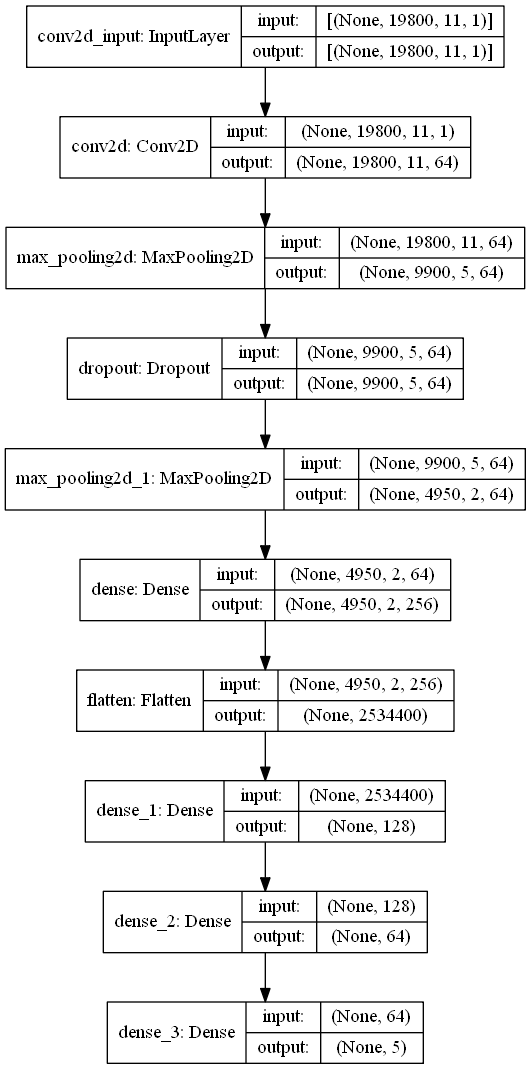

In [51]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [52]:
mod = model.fit(X_train,
               Y_train, epochs=200, batch_size= 32, verbose=2 , 
                callbacks=[callback, print_weights])

Epoch 1/200
5/5 - 37s - loss: 25.4338 - sparse_categorical_accuracy: 0.4932
Epoch 2/200
5/5 - 35s - loss: 3.5780 - sparse_categorical_accuracy: 0.7603
Epoch 3/200
5/5 - 35s - loss: 0.3137 - sparse_categorical_accuracy: 0.9589
Epoch 4/200
5/5 - 36s - loss: 0.1636 - sparse_categorical_accuracy: 0.9726
Epoch 5/200
5/5 - 39s - loss: 0.0270 - sparse_categorical_accuracy: 0.9932
Epoch 6/200
5/5 - 38s - loss: 0.0225 - sparse_categorical_accuracy: 0.9932
Epoch 7/200
5/5 - 39s - loss: 0.0214 - sparse_categorical_accuracy: 0.9932
Epoch 8/200
5/5 - 35s - loss: 0.0203 - sparse_categorical_accuracy: 0.9932
Epoch 9/200
5/5 - 36s - loss: 0.0164 - sparse_categorical_accuracy: 0.9932
Epoch 10/200
5/5 - 112s - loss: 0.0155 - sparse_categorical_accuracy: 0.9932
Epoch 11/200
5/5 - 94s - loss: 0.0133 - sparse_categorical_accuracy: 0.9932
Epoch 12/200
5/5 - 82s - loss: 0.0163 - sparse_categorical_accuracy: 0.9932
Epoch 13/200
5/5 - 79s - loss: 0.0103 - sparse_categorical_accuracy: 0.9932
Epoch 14/200
5/5 - 

In [53]:
len(wie_by_epoch)

29

In [55]:
#model.set_weights(wie_by_epoch[76])

In [56]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 6s - loss: 0.0155 - sparse_categorical_accuracy: 1.0000


[0.015538939274847507, 1.0]

In [57]:
dict(zip(model.metrics_names, scores))

{'loss': 0.015538939274847507, 'sparse_categorical_accuracy': 1.0}

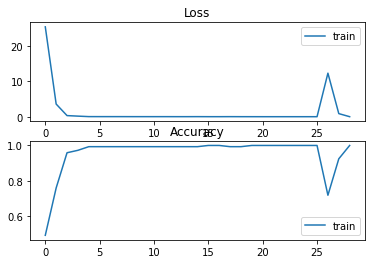

In [58]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [59]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [60]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [61]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [62]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [63]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


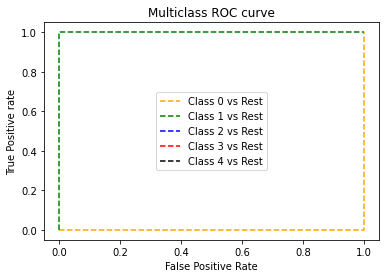

In [64]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [65]:
matrix = confusion_matrix(Y_test, yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [66]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [67]:
model.save('./models/IG feature selection/WithIP Top11/Binary/CNN')

INFO:tensorflow:Assets written to: ./models/IG feature selection/WithIP Top11/Binary/CNN\assets


In [ ]:
#FOr DNN model

In [45]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
#model_check = ModelCheckpoint("/models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [46]:
model = Sequential()
model.add(Flatten(input_shape = X_train.shape[1:], name = 'input'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(5, activation = 'softmax') )
#mod1 = model.compile(optimizer=tf.keras.optimizers.RMSprop(
#   learning_rate=0.1, rho=0.1, momentum=0.0, epsilon=1e-2 , centered=False,
#   name='RMSprop'), loss='sparse_categorical_crossentropy', metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])
#mod = model.fit(X.astype('float32'),Y.astype('float32'), epochs=20, batch_size= 20, verbose=0)

In [47]:
model.build(input_shape = (nx,ny))
model.output_shape

(None, 5)

In [48]:
#del model, wie_by_epoch

gc.collect()

361

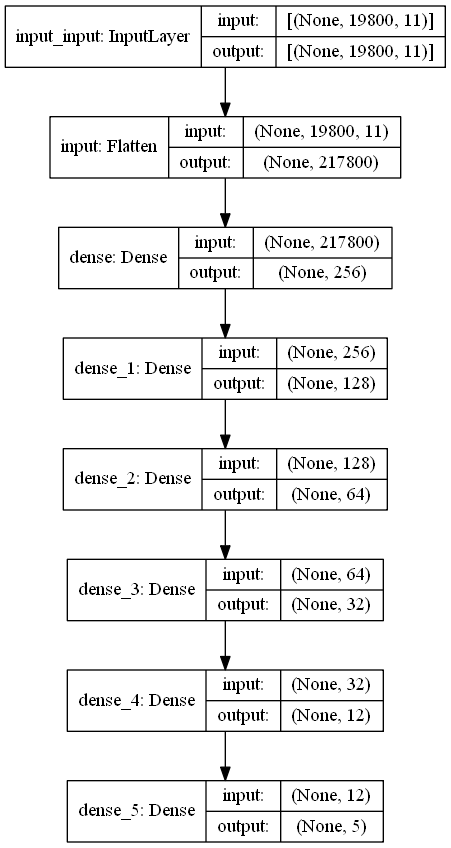

In [49]:
wights = model.get_weights()
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [50]:
mod = model.fit(X_train,
               Y_train, epochs=40, batch_size= 32, verbose=2 , 
                callbacks=[callback, print_weights])

Epoch 1/40
5/5 - 4s - loss: 12.0840 - sparse_categorical_accuracy: 0.4726
Epoch 2/40
5/5 - 2s - loss: 2.0953 - sparse_categorical_accuracy: 0.7808
Epoch 3/40
5/5 - 2s - loss: 3.1203 - sparse_categorical_accuracy: 0.8562
Epoch 4/40
5/5 - 2s - loss: 0.5858 - sparse_categorical_accuracy: 0.9247
Epoch 5/40
5/5 - 2s - loss: 0.0946 - sparse_categorical_accuracy: 0.9863
Epoch 6/40
5/5 - 2s - loss: 0.0136 - sparse_categorical_accuracy: 0.9932
Epoch 7/40
5/5 - 2s - loss: 0.0126 - sparse_categorical_accuracy: 0.9932
Epoch 8/40
5/5 - 2s - loss: 0.0114 - sparse_categorical_accuracy: 0.9932
Epoch 9/40
5/5 - 2s - loss: 0.0103 - sparse_categorical_accuracy: 0.9932
Epoch 10/40
5/5 - 2s - loss: 0.0094 - sparse_categorical_accuracy: 0.9932
Epoch 11/40
5/5 - 2s - loss: 0.0088 - sparse_categorical_accuracy: 0.9932
Epoch 12/40
5/5 - 2s - loss: 0.0081 - sparse_categorical_accuracy: 0.9932
Epoch 13/40
5/5 - 2s - loss: 0.0077 - sparse_categorical_accuracy: 0.9932
Epoch 14/40
5/5 - 2s - loss: 0.0069 - sparse_c

In [51]:
#Total Epochs
len(wie_by_epoch)

40

In [52]:
#
#model.set_weights(wie_by_epoch[37])

In [53]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 0s - loss: 0.0320 - sparse_categorical_accuracy: 1.0000


[0.03200048208236694, 1.0]

In [54]:
dict(zip(model.metrics_names, scores))

{'loss': 0.03200048208236694, 'sparse_categorical_accuracy': 1.0}

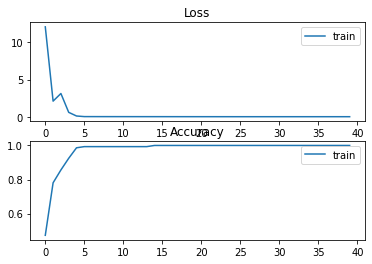

In [55]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [56]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [57]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


In [58]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [59]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [60]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


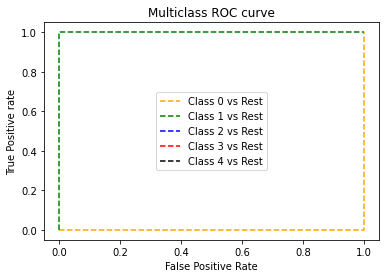

In [61]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [62]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [63]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [64]:
model.save('./models/IG feature selection/WithIP Top11/Binary/DNN')

INFO:tensorflow:Assets written to: ./models/IG feature selection/WithIP Top11/Binary/DNN\assets


In [65]:
from keras import backend as K
K.clear_session()

In [66]:
#LSTM

In [67]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
model_check = ModelCheckpoint("./models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [68]:
model = Sequential()
model.add(LSTM(14, activation='relu', return_sequences = True, dropout = 0.1, input_shape = (nx,ny) ))
model.add(Flatten())
model.add(Dense(5, activation='softmax'))
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [69]:
model.build(input_shape = (nx,ny))
model.output_shape

(None, 5)

In [70]:
#del model, wie_by_epoch

gc.collect()

15848

In [71]:
#model.build(input_shape = (nx,ny))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 19800, 14)         1456      
_________________________________________________________________
flatten (Flatten)            (None, 277200)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1386005   
Total params: 1,387,461
Trainable params: 1,387,461
Non-trainable params: 0
_________________________________________________________________


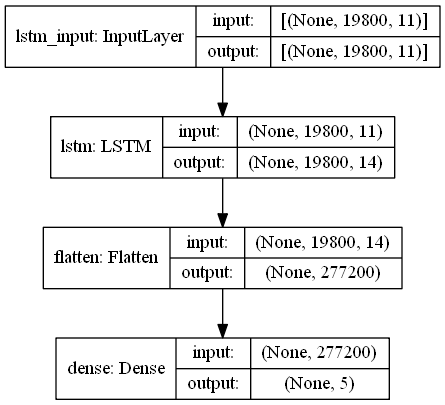

In [72]:
from tensorflow.keras.utils import plot_model
wights = model.get_weights()
plot_model(model, show_shapes=True)

In [73]:
mod = model.fit(X_train,
               Y_train, epochs=60, batch_size= 64, verbose=2 , 
                callbacks=[callback, print_weights, model_check])

Epoch 1/60
3/3 - 38s - loss: 2.3029 - sparse_categorical_accuracy: 0.4795
Epoch 2/60
3/3 - 43s - loss: 0.5968 - sparse_categorical_accuracy: 0.8836
Epoch 3/60
3/3 - 40s - loss: 1.3857 - sparse_categorical_accuracy: 0.8082
Epoch 4/60
3/3 - 40s - loss: 0.2175 - sparse_categorical_accuracy: 0.9726
Epoch 5/60
3/3 - 42s - loss: 0.1104 - sparse_categorical_accuracy: 0.9863
Epoch 6/60
3/3 - 42s - loss: 0.0538 - sparse_categorical_accuracy: 0.9863
Epoch 7/60
3/3 - 42s - loss: 0.0222 - sparse_categorical_accuracy: 0.9932
Epoch 8/60
3/3 - 46s - loss: 0.0224 - sparse_categorical_accuracy: 0.9932
Epoch 9/60
3/3 - 43s - loss: 0.0202 - sparse_categorical_accuracy: 0.9932
Epoch 10/60
3/3 - 41s - loss: 0.0191 - sparse_categorical_accuracy: 0.9932
Epoch 11/60
3/3 - 40s - loss: 0.0195 - sparse_categorical_accuracy: 0.9932
Epoch 12/60
3/3 - 41s - loss: 0.0182 - sparse_categorical_accuracy: 0.9932
Epoch 13/60
3/3 - 41s - loss: 0.0184 - sparse_categorical_accuracy: 0.9932
Epoch 14/60
3/3 - 42s - loss: 0.01

In [74]:
# Number of Epochs
len(wie_by_epoch)

40

In [76]:
# 7
#model.set_weights(wie_by_epoch[45])

In [77]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 4s - loss: 0.0042 - sparse_categorical_accuracy: 1.0000


[0.004213772714138031, 1.0]

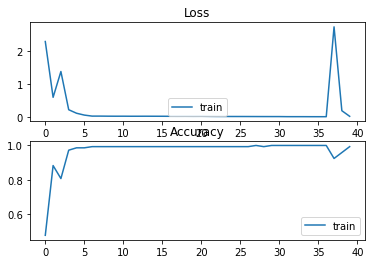

In [78]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [79]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [80]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [81]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [82]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


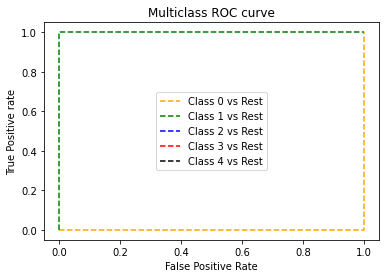

In [83]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [84]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [85]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [86]:
import pickle
#filename = './models/CFS feature selection/With IP_ Top 7/Multi-class/KNN/KNN.sav'
model.save('./models/IG feature selection/WithIP Top11/Binary/LSTM')

INFO:tensorflow:Assets written to: ./models/IG feature selection/WithIP Top11/Binary/LSTM\assets


In [87]:
from keras import backend as K
K.clear_session()

In [88]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LambdaCallback
wie_by_epoch = []
model_check = ModelCheckpoint("./models/Testpoints/best_model.hdf5", monitor='loss', verbose=0, save_best_only=True, mode='min', save_freq=1)
print_weights = LambdaCallback(on_epoch_end=lambda batch, logs:wie_by_epoch.append(model.get_weights()))
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4, verbose= 2)

In [89]:
model = Sequential()
model.add(SimpleRNN(16, input_shape=(nx, ny), return_sequences = True, activation='relu'))
model.add(Flatten())
model.add(Dense(units=5, activation='softmax'))
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy',  metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [90]:
model.build(input_shape = (nx,ny))
model.output_shape

(None, 5)

In [91]:
#del model, wie_by_epoch

gc.collect()

72719

In [92]:
#model.build(input_shape = (nx,ny))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 19800, 16)         448       
_________________________________________________________________
flatten (Flatten)            (None, 316800)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 1584005   
Total params: 1,584,453
Trainable params: 1,584,453
Non-trainable params: 0
_________________________________________________________________


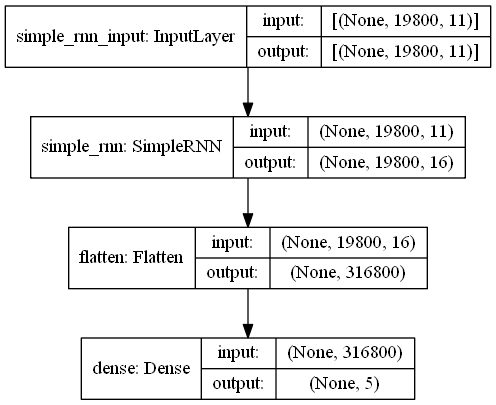

In [93]:
from tensorflow.keras.utils import plot_model
wights = model.get_weights()
plot_model(model, show_shapes=True)

In [94]:
mod = model.fit(X_train,
               Y_train, epochs=60, batch_size= 32, verbose=2 , 
                callbacks=[callback, print_weights, model_check])

Epoch 1/60
5/5 - 28s - loss: 7.9491 - sparse_categorical_accuracy: 0.6301
Epoch 2/60
5/5 - 27s - loss: 0.6229 - sparse_categorical_accuracy: 0.9521
Epoch 3/60
5/5 - 31s - loss: 0.0380 - sparse_categorical_accuracy: 0.9863
Epoch 4/60
5/5 - 32s - loss: 0.0200 - sparse_categorical_accuracy: 0.9932
Epoch 5/60
5/5 - 32s - loss: 0.0174 - sparse_categorical_accuracy: 0.9932
Epoch 6/60
5/5 - 31s - loss: 0.0175 - sparse_categorical_accuracy: 0.9932
Epoch 7/60
5/5 - 31s - loss: 0.0189 - sparse_categorical_accuracy: 0.9932
Epoch 8/60
5/5 - 31s - loss: 0.0162 - sparse_categorical_accuracy: 0.9932
Epoch 9/60
5/5 - 32s - loss: 0.0134 - sparse_categorical_accuracy: 0.9932
Epoch 10/60
5/5 - 31s - loss: 0.0132 - sparse_categorical_accuracy: 0.9932
Epoch 11/60
5/5 - 31s - loss: 0.0121 - sparse_categorical_accuracy: 0.9932
Epoch 12/60
5/5 - 31s - loss: 0.0104 - sparse_categorical_accuracy: 0.9932
Epoch 13/60
5/5 - 31s - loss: 0.0094 - sparse_categorical_accuracy: 0.9932
Epoch 14/60
5/5 - 31s - loss: 0.00

In [95]:
#Number of Epochs
len(wie_by_epoch)

38

In [96]:
#120 +21
#model.set_weights(wie_by_epoch[95])
#mod.history.get('sparse_categorical_accuracy')

In [97]:
scores = model.evaluate(X_test,Y_test, verbose=2)
scores

2/2 - 3s - loss: 0.0011 - sparse_categorical_accuracy: 1.0000


[0.0011153246741741896, 1.0]

In [98]:
dict(zip(model.metrics_names, scores))

{'loss': 0.0011153246741741896, 'sparse_categorical_accuracy': 1.0}

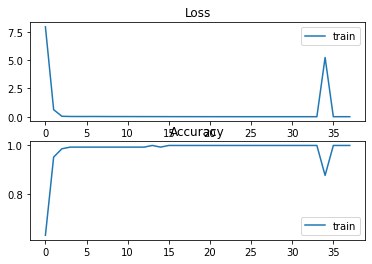

In [99]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(mod.history['loss'], label='train')
#pyplot.plot(mod.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(mod.history['sparse_categorical_accuracy'], label='train')
#pyplot.plot(mod.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [100]:
# predict probabilities for test set
yhat_probs = model.predict(X_test.astype('float32'), verbose=0)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = np.argmax(yhat_probs,axis=1)

In [101]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [102]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [103]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


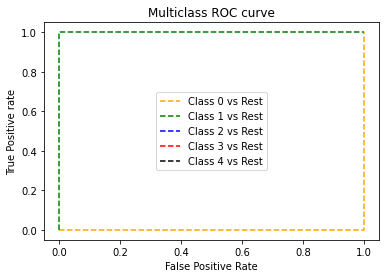

In [104]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [105]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [106]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [107]:
import pickle
model.save('./models/IG feature selection/WithIP Top11/Binary/Simple RNN')

INFO:tensorflow:Assets written to: ./models/IG feature selection/WithIP Top11/Binary/Simple RNN\assets


In [ ]:
#MLP

In [108]:
#X = make_4D(X)
nsamples,nx, ny = X_test.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny}" )
X_test = X_test.reshape((nsamples,nx*ny))

samples: 37 
 X:19800 
 Y:11


In [109]:
nsamples,nx, ny = X_train.shape
print(f"samples: {nsamples} \n X:{nx} \n Y:{ny}" )
X_train = X_train.reshape((nsamples,nx*ny))

samples: 146 
 X:19800 
 Y:11


In [110]:
from sklearn.neural_network import MLPClassifier

In [111]:
clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1).fit(X_train, Y_train)
y_pred=clf.predict(X_test)


In [112]:
clf.score(X_test, Y_test)

0.9459459459459459

In [113]:
yhat_classes = y_pred

In [114]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve


In [115]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 0.945946
Precision: 0.941176
Recall: 0.954545
F1 score: 0.944940


In [116]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 0.890208
[[20  2]
 [ 0 15]]


In [117]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


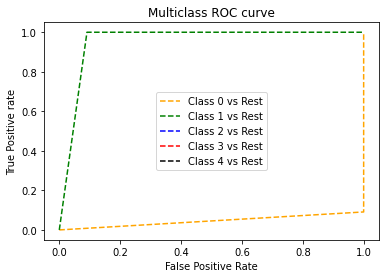

In [118]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [119]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
matrix = confusion_matrix(Y_test, yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[20  2]
 [ 0 15]]


In [120]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95        22
           1       0.88      1.00      0.94        15

    accuracy                           0.95        37
   macro avg       0.94      0.95      0.94        37
weighted avg       0.95      0.95      0.95        37



In [121]:
import pickle
# save the model to disk
filename = './models/IG feature selection/WithIP Top11/Binary/MLP/MLP.sav'
pickle.dump(clf, open(filename, 'wb'))

In [122]:
#DBN model
from dbn.tensorflow import SupervisedDBNClassification

Instructions for updating:
non-resource variables are not supported in the long term


In [144]:
classifier = SupervisedDBNClassification(hidden_layers_structure=[64,64],
                                         learning_rate_rbm=0.00001,
                                         learning_rate=0.01,
                                         n_epochs_rbm=32,
                                         n_iter_backprop=512,
                                         batch_size=32,
                                         activation_function='relu',
                                         dropout_p=0.00001)

In [143]:
del classifier
gc.collect()

106

In [145]:
classifier.fit(X_train, Y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 13094.500977
>> Epoch 2 finished 	RBM Reconstruction error 13094.230469
>> Epoch 3 finished 	RBM Reconstruction error 13093.945312
>> Epoch 4 finished 	RBM Reconstruction error 13093.654297
>> Epoch 5 finished 	RBM Reconstruction error 13093.332031
>> Epoch 6 finished 	RBM Reconstruction error 13092.995117
>> Epoch 7 finished 	RBM Reconstruction error 13092.575195
>> Epoch 8 finished 	RBM Reconstruction error 13092.058594
>> Epoch 9 finished 	RBM Reconstruction error 13091.390625
>> Epoch 10 finished 	RBM Reconstruction error 13090.479492
>> Epoch 11 finished 	RBM Reconstruction error 13089.276367
>> Epoch 12 finished 	RBM Reconstruction error 13087.504883
>> Epoch 13 finished 	RBM Reconstruction error 13085.301758
>> Epoch 14 finished 	RBM Reconstruction error 13082.070312
>> Epoch 15 finished 	RBM Reconstruction error 13077.871094
>> Epoch 16 finished 	RBM Reconstruction error 13072.093750
>> Epoch 17 finished 	

>> Epoch 90 finished 	ANN training loss 0.040915
>> Epoch 91 finished 	ANN training loss 0.039868
>> Epoch 92 finished 	ANN training loss 0.038772
>> Epoch 93 finished 	ANN training loss 0.037782
>> Epoch 94 finished 	ANN training loss 0.036789
>> Epoch 95 finished 	ANN training loss 0.035919
>> Epoch 96 finished 	ANN training loss 0.035031
>> Epoch 97 finished 	ANN training loss 0.034236
>> Epoch 98 finished 	ANN training loss 0.033446
>> Epoch 99 finished 	ANN training loss 0.032737
>> Epoch 100 finished 	ANN training loss 0.032020
>> Epoch 101 finished 	ANN training loss 0.031343
>> Epoch 102 finished 	ANN training loss 0.030690
>> Epoch 103 finished 	ANN training loss 0.030060
>> Epoch 104 finished 	ANN training loss 0.029481
>> Epoch 105 finished 	ANN training loss 0.028916
>> Epoch 106 finished 	ANN training loss 0.028367
>> Epoch 107 finished 	ANN training loss 0.027880
>> Epoch 108 finished 	ANN training loss 0.027416
>> Epoch 109 finished 	ANN training loss 0.026952
>> Epoch 1

>> Epoch 255 finished 	ANN training loss 0.012293
>> Epoch 256 finished 	ANN training loss 0.012266
>> Epoch 257 finished 	ANN training loss 0.012241
>> Epoch 258 finished 	ANN training loss 0.012212
>> Epoch 259 finished 	ANN training loss 0.012188
>> Epoch 260 finished 	ANN training loss 0.012162
>> Epoch 261 finished 	ANN training loss 0.012136
>> Epoch 262 finished 	ANN training loss 0.012108
>> Epoch 263 finished 	ANN training loss 0.012084
>> Epoch 264 finished 	ANN training loss 0.012061
>> Epoch 265 finished 	ANN training loss 0.012039
>> Epoch 266 finished 	ANN training loss 0.012017
>> Epoch 267 finished 	ANN training loss 0.011995
>> Epoch 268 finished 	ANN training loss 0.011973
>> Epoch 269 finished 	ANN training loss 0.011952
>> Epoch 270 finished 	ANN training loss 0.011929
>> Epoch 271 finished 	ANN training loss 0.011907
>> Epoch 272 finished 	ANN training loss 0.011885
>> Epoch 273 finished 	ANN training loss 0.011864
>> Epoch 274 finished 	ANN training loss 0.011840


>> Epoch 419 finished 	ANN training loss 0.009682
>> Epoch 420 finished 	ANN training loss 0.009671
>> Epoch 421 finished 	ANN training loss 0.009661
>> Epoch 422 finished 	ANN training loss 0.009653
>> Epoch 423 finished 	ANN training loss 0.009644
>> Epoch 424 finished 	ANN training loss 0.009632
>> Epoch 425 finished 	ANN training loss 0.009621
>> Epoch 426 finished 	ANN training loss 0.009612
>> Epoch 427 finished 	ANN training loss 0.009603
>> Epoch 428 finished 	ANN training loss 0.009592
>> Epoch 429 finished 	ANN training loss 0.009583
>> Epoch 430 finished 	ANN training loss 0.009575
>> Epoch 431 finished 	ANN training loss 0.009566
>> Epoch 432 finished 	ANN training loss 0.009556
>> Epoch 433 finished 	ANN training loss 0.009548
>> Epoch 434 finished 	ANN training loss 0.009538
>> Epoch 435 finished 	ANN training loss 0.009528
>> Epoch 436 finished 	ANN training loss 0.009519
>> Epoch 437 finished 	ANN training loss 0.009509
>> Epoch 438 finished 	ANN training loss 0.009500


SupervisedDBNClassification(batch_size=32, dropout_p=1e-05,
                            idx_to_label_map={0: 0, 1: 1},
                            l2_regularization=1.0,
                            label_to_idx_map={0: 0, 1: 1}, learning_rate=0.01,
                            n_iter_backprop=512, verbose=True)

In [146]:
# predict probabilities for test set
yhat_probs = classifier.predict(X_test)
# predict crisp classes for test set
#yhat_classes = model.predict_classes(X_test, verbose=0)
yhat_classes = yhat_probs# np.argmax(yhat_probs,axis=1)

In [147]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [148]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yhat_classes, average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yhat_classes,average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Y_test, yhat_classes, average='macro')
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


In [149]:
# kappa
kappa = cohen_kappa_score(Y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
#fprate, tprate, thresholds = roc_curve(Y_test, yhat_probs, average = 'macro')
#print('ROC AUC: %f' % thresholds)
# confusion matrix
matrix = confusion_matrix(Y_test, yhat_classes)
print(matrix)

Cohens kappa: 1.000000
[[22  0]
 [ 0 15]]


In [150]:
fpr = {}
tpr = {}
thresh ={}

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test, yhat_classes, pos_label=i)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


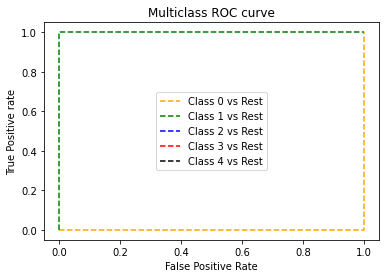

In [151]:
# plotting    
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Class 3 vs Rest')
plt.plot(fpr[4], tpr[4], linestyle='--',color='black', label='Class 4 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300); 

In [152]:
matrix = confusion_matrix(Y_test,yhat_classes, labels= [0, 1])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[22  0]
 [ 0 15]]


In [153]:
matrix = classification_report(Y_test,yhat_classes, labels= [0, 1])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [155]:
classifier.save('./models/IG feature selection/WithIP Top11/Binary/DBN/DBN.pkl')